# Предсказание моих шахматных результатов. Ход конём

Приветствую всех! Что собственно говоря, происходит?

Меня зовут Максим, и я шахматист. Я играю в шахматы с 3 лет, и это был мой осознанный выбор (конечно же нет). Я имею звание КМС и очень люблю играть в шахматы онлайн. Я сейчас играю на одном из лучших сайтов для игры в шахматы онлайн - lichess.org. На апрель 2021 года у меня было сыграно около 2000 партий, в основном это блиц (blitz, контроль времени 3-5 минут на партию) или пуля (bullet, контроль времени 1-2 минуты на партию). Мне стало интересно, возможно ли предсказать с достаточной точностью, выиграю ли я определенную партию или нет, исходя из данных, которые можно собрать с сайта lichess? Я скачал базу моих партий с этого сайта и начал разбираться...

## 1. Постановка задачи. Обзор имеющихся данных

Загружаем нужные библиотеки для начала

In [1]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from chess_lib import create_df_from_pgn, create_my_result, plot_auc_roc, count_rate, fit_model
from itertools import combinations

Здесь библиотека chess_lib - это файл, который я создал сам. В нём содержатся функции для парсинга pgn файла и создания из его содержимого Dataframe, создания целевой переменной и прочие вспомогательные функции. Когда я буду пользоваться функцией из этой библиотечки, я укажу это в тексте

База данных партий хранится в файле формата .pgn (это такой стандарт для шахматных баз данных). Это по сути, текстовый файл, отформатированный определенным образом. Давайте взглянем на его кусочек.

In [2]:
with open('C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-04-20.pgn', 'r', encoding='utf-8') as f:
    text_file = f.read()
print(text_file[:1000])

[Event "Rated Bullet game"]
[Site "https://lichess.org/XvR2rQFZ"]
[Date "2021.04.20"]
[White "AlexanderChetverik"]
[Black "shahmatpatblog"]
[Result "1-0"]
[UTCDate "2021.04.20"]
[UTCTime "08:27:29"]
[WhiteElo "2058"]
[BlackElo "2194"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "120+1"]
[ECO "A45"]
[Termination "Normal"]

1. d4 Nf6 2. f4 d5 3. Nf3 c5 4. e3 Nc6 5. b3 g6 6. dxc5 Bg7 7. Bb2 Qa5+ 8. Nbd2 Qxc5 9. Nd4 Bg4 10. Be2 Bxe2 11. Qxe2 O-O 12. O-O Nxd4 13. Bxd4 Qxc2 14. Rfc1 Qf5 15. Rc7 b6 16. Rxe7 Rfe8 17. Rxe8+ Rxe8 18. Qb5 Qd7 19. Qxd7 Nxd7 20. Bxg7 Kxg7 21. Kf2 Nc5 22. Rd1 a5 23. g4 f6 24. Kf3 Kf7 25. Nb1 Ke6 26. Nc3 Rd8 27. h4 h6 28. Nb5 Rd7 29. Nd4+ Kf7 30. f5 g5 31. h5 Ne4 32. Nb5 Ke7 33. Rd3 Nc5 34. Rd4 Rd8 35. Nc3 Rd6 36. Nxd5+ Kf7 37. Nc3 Rxd4 38. exd4 Nb7 39. Ke4 Ke7 40. Nb5 Kd7 41. d5 Nc5+ 42. Kd4 Nb7 43. Nc3 Nd6 44. Ne4 Nb5+ 45. Kc4 Na3+ 46. Kd3 b5 47. Nxf6+ Kd6 48. Ne4+ Kxd5 49. Nf6+ Ke5 50. Ng8 Kf4 51. Nxh6 b4 52. f6 Nb5 53. f7 1-0



Здесь, для примера, отображена информация о последней (по хронометражу) игре. Данным образом форматируется каждая партия в базе. Структура следующая: вначале идёт заголовок партии, затем ходы партии, затем предыдущая партия и т.д. Мы можем воспользоваться следующей информацией:

Event - тип события. Может быть обычная блиц партия, обычная пуля-партия, какой-нибудь турнир (если сыграна в турнире)

Site - ссылка на страничку партии

Date - дата партии

White - никнейм игрока, играющего белыми

Black - никнейм игрока, играющего черными

Result - результат партии (1-0, 0-1, 1/2-1/2)

UTCDate - дата UTC

UTCTime - время UTC (-4 часа от моего часового пояса)

WhiteElo - рейтинг (Elo) белых

BlackElo - рейтинг (Elo) черных

WhiteRatingDiff - изменение рейтинга белых по результату данной партии

BlackRatingDiff - изменение рейтинга черных по результату данной партии

Variant - тип выбранного режима игры (обычные, шахматы Фишера, поддавки и т.п.). Я играю только обычные (Standard)

TimeControl - контроль времени. "180+2" например, значит, что контроль времени 3 минуты (180 с) с добавлением 2 с на ход.

ECO - дебютный индекс партии. Определяет, какой дебют был разыгран в партии

Termination - тип окончания партии. Нормальное значит кто-то сдался, или мат, или согласились на ничью. Может быть еще просрочка времени

Набор ходов партии в виде стандартной шахматной нотации

In [3]:
path_to_file = 'C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-04-20.pgn'
feature_names = ['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'TimeControl', 'ECO']

Я скачал базу данных своих партий на 20.04.2021 в формате .pgn, которая содержит в текстовом виде информацию о сыгранных мной партиях на сайте lichess.org. Она содержит 1952 партий за период 05.2020 - 04.2021. Часть этих партий будет использоваться для обучения, другая часть - для проверки модели. Выше я прописал путь к файлу и задал список параметров, которые я хочу выдернуть из базы данных. Мне нужны далеко не все из имеющихся данных.

Моя задача - предсказать результат партий из тестового набора игр (разобью базу данных при помощи train_test_split позже). Предсказание заключается в определении, выиграю ли я эту партию или нет. Это задача бинарной классификации. Для упрощения задачи, ничейные результаты принимаются за поражения (ничьи в блиц бывают редко и их очень трудно предсказать).

## 2. Предобработка данных

Для просмотра кода моих функций см. файл chess_lib.py. Функция create_df_from_pgn() преобразует файл .pgn в датафрейм с указанным набором параметров (тот, который feature_names). Переменная raw_data, таким образом, это стартовый датафрейм, готорый я буду анализировать и разбирать, чтобы создать набор данных для обучения и проверки модели.

In [4]:
raw_data = create_df_from_pgn(path_to_file, feature_names)

In [5]:
print('Размерность исходного датасета:', raw_data.shape)
raw_data.head()

Размерность исходного датасета: (1952, 10)


,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,TimeControl,ECO
0,Rated Bullet game,AlexanderChetverik,shahmatpatblog,1-0,2021.04.20,08:27:29,2058,2194,120+1,A45
1,Rated Bullet game,shahmatpatblog,voldemar70,1-0,2021.04.20,08:25:05,2190,2089,120+1,C41
2,Rated Bullet game,keres123,shahmatpatblog,1/2-1/2,2021.04.20,08:18:42,2191,2190,120+1,C56
3,WFM Chess Blondinka Stream Arena,shahmatpatblog,Valera200707,1-0,2021.04.19,18:04:41,2342,2273,180+0,A45
4,WFM Chess Blondinka Stream Arena,Santexnik,shahmatpatblog,0-1,2021.04.19,18:04:12,1595,2342,180+0,?


Да, кстати. Мой никнейм - shahmatpatblog. Он будет в каждой партии, так как это моя база партий.

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Event        1952 non-null   object
 1   White        1952 non-null   object
 2   Black        1952 non-null   object
 3   Result       1952 non-null   object
 4   UTCDate      1952 non-null   object
 5   UTCTime      1952 non-null   object
 6   WhiteElo     1952 non-null   object
 7   BlackElo     1952 non-null   object
 8   TimeControl  1952 non-null   object
 9   ECO          1952 non-null   object
dtypes: object(10)
memory usage: 76.3+ KB


Т.к. данные парсились из текстового файла, то все поля в таблице имеют тип 'object'. Это строковые объекты (str). Пропусков данных нет

In [7]:
raw_data.describe()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,TimeControl,ECO
count,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952
unique,47,917,928,3,255,1909,538,543,10,198
top,Rated Blitz game,shahmatpatblog,shahmatpatblog,1-0,2021.03.21,14:06:45,2247,2194,180+2,A45
freq,1019,974,978,928,48,3,16,15,1038,378


Наиболее часто играемые события (Event) - Rated Blitz game (не турнирная блиц-игра). Чаще всего выигрывают белые (Result = 1-0). Наиболее предпочитаемый мной контроль времени (TimeControl) - 180+2. Чаще всего из дебютов (ECO) встречается A45 (он же Атака Тромповского)

#### Создам датафрейм chess_df, в который буду закидывать сгенерированные на основе анализа raw_data фичи для обучения классификатора. Для удобства буду называть его основной датафрейм

In [8]:
chess_df = pd.DataFrame()

#### Для начала полезно будет добавить в наш датафрейм признаки даты и времени

In [9]:
chess_df['Date_Time'] = raw_data['UTCDate'] + ' ' + raw_data['UTCTime']
chess_df[['Date_Time']] = chess_df[['Date_Time']].applymap(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))
chess_df[['date_']] = raw_data[['UTCDate']].applymap(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d'))
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 2)


,Date_Time,date_
0,2021-04-20 08:27:29,2021-04-20
1,2021-04-20 08:25:05,2021-04-20
2,2021-04-20 08:18:42,2021-04-20
3,2021-04-19 18:04:41,2021-04-19
4,2021-04-19 18:04:12,2021-04-19


#### Далее в основной датафрейм добавлю целевую переменную - результат моей игры. 1- я выиграл, 0 - не выиграл.

Столбцы White, Black и Result пригодятся для создания целевой переменной. Для этого я прописал функцию create_my_result (см. файл chess_lib.py), которая создает помимо прочего, фичу my_color - цвет, которым я играл: белыми (1) или черными (0)

In [10]:
color_and_result = create_my_result(raw_data)
chess_df['my_result'] = color_and_result['my_result'].astype('uint8')
chess_df['my_color'] = color_and_result['my_color'].astype('uint8')

In [11]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 4)


,Date_Time,date_,my_result,my_color
0,2021-04-20 08:27:29,2021-04-20,0,0
1,2021-04-20 08:25:05,2021-04-20,1,1
2,2021-04-20 08:18:42,2021-04-20,0,0
3,2021-04-19 18:04:41,2021-04-19,1,1
4,2021-04-19 18:04:12,2021-04-19,1,0


Давайте взглянем на распределение целевой переменной my_result.

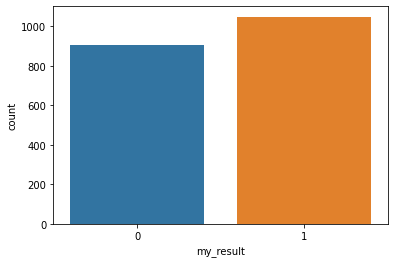

In [12]:
sns.countplot(x='my_result', data=chess_df);

Доля классов 0 и 1 примерно одинаковая. Как мы видим, выигрываю я почаще

<AxesSubplot:xlabel='percent_of_wins', ylabel='my_color'>

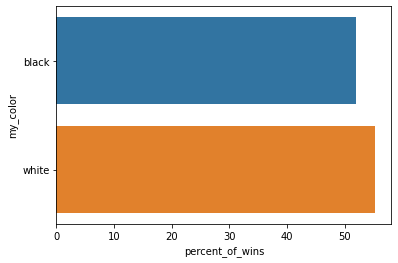

In [13]:
a = chess_df.groupby('my_color').agg({'my_result': 'mean'}).reset_index()
a = a.replace({0: 'black', 1: 'white'})
a.my_result = a.my_result * 100
a = a.rename(columns={'my_result': 'percent_of_wins'})
sns.barplot(x=a.percent_of_wins, y=a.my_color, orient='h')

также статистика говорит, что белым цветом я выигрываю почаще (55% партий), чем черными (52%)

#### Далее проанализируем и преобразуем колонку Events

<AxesSubplot:xlabel='Event', ylabel='index'>

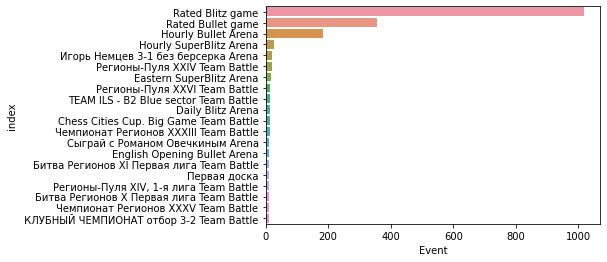

In [14]:
events = raw_data.Event.value_counts().to_frame().reset_index().head(20)
sns.barplot(data=events, x='Event', y='index')

Наиболее часто встречаемые события - не турнирные игры (Rated Blitz game, Rated Bullet game). Остальное - это игры, сыгранные в различных турнирах. На основании этого предлагаю сделать категориальную переменную Event, где 0 - это не турнирные игры, 1 - турнирные (все остальные). Разделять Blitz game и Bullet game не вижу смысла, так как это разделение будет в переменной, отвечающей за контроль времени.

In [15]:
chess_df['event'] = raw_data.Event.replace(['Rated Blitz game', 'Rated Bullet game', 'Casual Blitz game'], 0)
chess_df.loc[chess_df.event != 0, 'event'] = 1
chess_df['event'] = chess_df['event'].astype('uint8')

In [16]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 5)


,Date_Time,date_,my_result,my_color,event
0,2021-04-20 08:27:29,2021-04-20,0,0,0
1,2021-04-20 08:25:05,2021-04-20,1,1,0
2,2021-04-20 08:18:42,2021-04-20,0,0,0
3,2021-04-19 18:04:41,2021-04-19,1,1,1
4,2021-04-19 18:04:12,2021-04-19,1,0,1


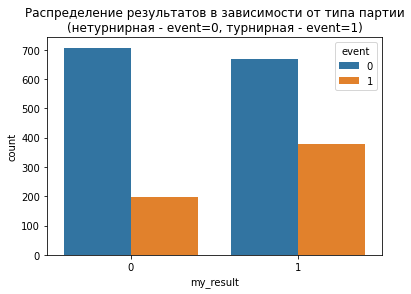

In [17]:
sns.countplot(x='my_result', hue='event', data=chess_df)
plt.title('Распределение результатов в зависимости от типа партии\n(нетурнирная - event=0, турнирная - event=1)');

По данной диаграммеможно сказать, что количество побед и поражений в нетурнирных партиях почти одинаковое, а вот в турнирах доля побед значительно возрастает

#### Добавляю переменные my_rating (мой текущий рейтинг) и rating_diff (разница между моим рейтингом и рейтингом соперника)

In [18]:
chess_df['my_rating'] = raw_data['WhiteElo'].where(raw_data['White'] == 'shahmatpatblog', raw_data['BlackElo']).astype('uint16')

In [19]:
chess_df['rating_diff'] = raw_data['WhiteElo'].astype('int16') - raw_data['BlackElo'].astype('int16')
chess_df['rating_diff'] = chess_df['rating_diff'].where(chess_df['my_color'] == 1, -chess_df['rating_diff'])

In [20]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 7)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747


Значение текущего рейтинга и разность моего рейтинга с соперником - весьма сильные признаки. Давайте взглянем на их скэттер плот в зависимости от результата партии 

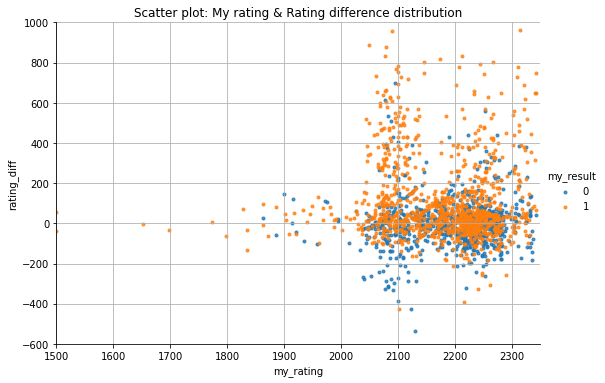

In [21]:
ax = sns.lmplot(x='my_rating', y='rating_diff', data=chess_df, hue='my_result', fit_reg=False, markers='.', aspect=1.5)
plt.title('Scatter plot: My rating & Rating difference distribution')
plt.grid()
plt.xlim([1500, 2350])
plt.ylim([-600, 1000]);

Как мы видим, чем больше мой рейтинг над рейтингом соперника (rating_diff > 0), тем чаще я побеждаю, и наоборот. Что, собственно говоря, предельно логично

#### На основе анализа колонки TimeControl создаю категориальную переменную time_control, указывающую тип контроля времени

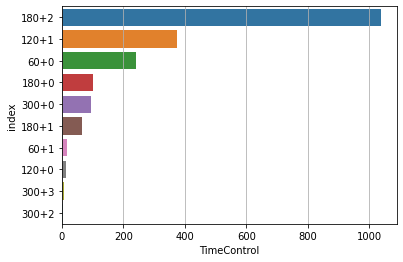

In [22]:
sns.barplot(data=raw_data.TimeControl.value_counts().to_frame().reset_index(), x='TimeControl', y='index')
plt.grid(axis='x')

Давайте разбираться в контролях времени. Больше половины партий я сыграл с контролем 180+2 (3 минуты с добавлением 2 с на ход). Немало партий в пулю - 120+1 (т.н "ленивая пуля") и 60+0 ("обычная пуля"). Предлагаю близкие по таймингу типы контроля времени объединить в две основные группы - пуля (0) и блиц (1). Таким образом для переменной time_contol, которую я создаю следующие категории: 0 - 60+0, 60+1, 120+0, 120+1, 1 - 180+0, 180+1, 180+2, 300+0, 300+2, 300+3

In [23]:
chess_df['time_control'] = raw_data.TimeControl.replace(['60+0', '60+1', '120+0', '120+1'], 0) \
                                    .replace(['180+0', '180+1', '180+2', '300+0', '300+2', '300+3'], 1)
chess_df['time_control'] = chess_df['time_control'].astype('uint8')

In [24]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 8)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1


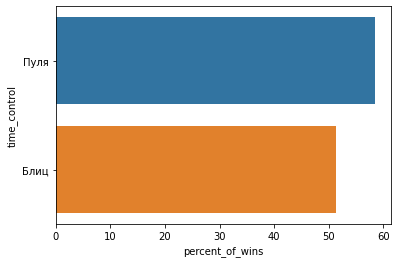

In [25]:
b = chess_df.groupby('time_control').agg({'my_result': 'mean'}).reset_index()
b = b.replace({0: 'Пуля', 1: 'Блиц'})
b.my_result = b.my_result * 100
b = b.rename(columns={'my_result': 'percent_of_wins'})
sns.barplot(x=b.percent_of_wins, y=b.time_control, orient='h');

Как оказалось, в пулю процент побед у меня больше. Это можно объяснить, что пока я еще не набрал свой максимальный рейтинг в пулю, т.к. играю в нее меньше, и сильных соперников там меньше, чем в блиц.

Кстати, глянем на изменение моего рейтинга по времени. Поскольку я играю в двух режимах - блиц и пуля, рейтинга будет два

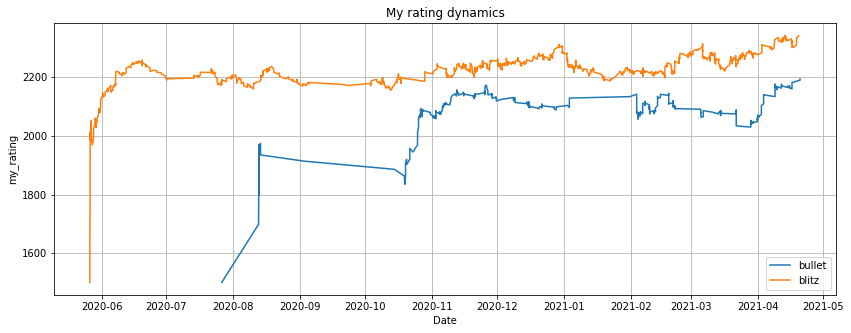

In [26]:
plt.figure(figsize=(14, 5))
ax = sns.lineplot(x=chess_df.Date_Time, y=chess_df.my_rating, hue=chess_df.time_control)
ax.xaxis.set_label_text('Date')
plt.legend(('bullet', 'blitz'), loc='lower right')
plt.grid()
plt.title('My rating dynamics');

#### Добавляю переменные - день недели и час суток игры (вдруг есть зависимость с моими результатами, например, в рабочие дни играю хуже, чем в выходные, вечером лучше, чем утром)

Создаю: day_of_week - категориальная переменная, от 1 до 7, обозначающая день недели игры (1 - Monday, ..., 7 - Sunday)

hour_of_game - час суток (время UTF, т.е. для получения моего времени надо прибавить +4 часа)

In [27]:
chess_df[['day_of_week']] = chess_df[['Date_Time']].applymap(lambda x: x.isoweekday()).astype('uint8')
chess_df[['hour_of_game']] = chess_df[['Date_Time']].applymap(lambda z: z.time().hour + 4).astype('uint8')

In [28]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 10)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control,day_of_week,hour_of_game
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0,2,12
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0,2,12
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0,2,12
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1,1,22
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1,1,22


Гистограмма распределения результатов по дням недели выгляди так:

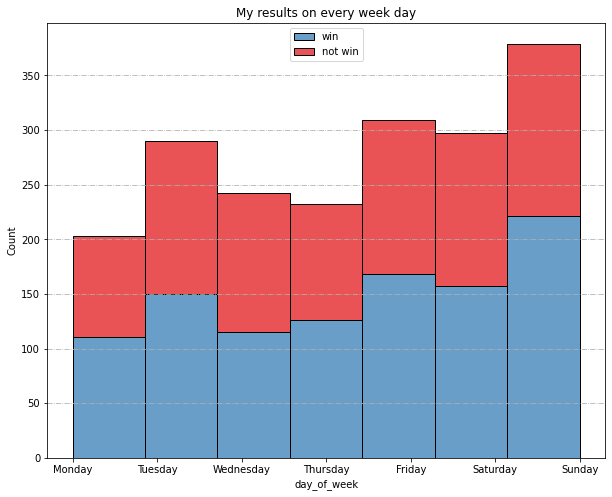

In [29]:
plt.figure(figsize=(10, 8))
sns.histplot(data=chess_df, x=chess_df.day_of_week, hue='my_result', bins=7, multiple='stack', palette='Set1')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend(('win', 'not win'), loc='upper center')
plt.grid(axis='y', linestyle='-.')
plt.title('My results on every week day')
plt.plot();

К выходным количество игр возрастает, и наибольшая доля побед именно в выходные. Логично, ведь я свеж и не отвлекаюсь на работу :)

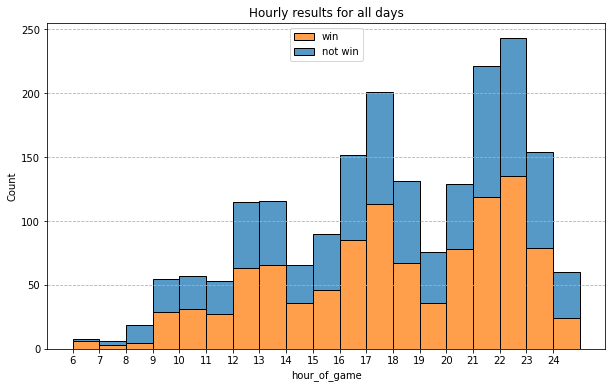

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=chess_df, x=chess_df.hour_of_game, hue='my_result', bins=19, multiple='stack')
plt.xticks(ticks=range(25))
plt.legend(('win', 'not win'), loc='upper center')
plt.grid(axis='y', linestyle='--')
plt.title('Hourly results for all days')
plt.plot();

Из почасового распределения результатов можно сделать несколько интересных замечаний. Во-первых, есть несколько пиков - отрезков времени, когда я чаще всего играю. Это 12-13 часов (обеденный перерыв), 16-18 часов (окончание работы, еду домой), 20-23 (вечернее время дома). Во-вторых, есть "плохие" часы, когда результаты не очень (в начале дня, поздно вечером), и "хорошие часы", когда я чаще бываю в ударе. В-третьих, интересно посмотреть на это распределение только для рабочих дней и только для выходных.

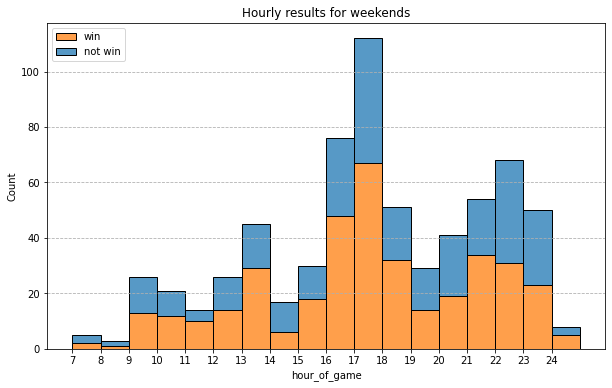

In [31]:
weekend = chess_df[chess_df.day_of_week >= 6]
plt.figure(figsize=(10, 6))
sns.histplot(data=weekend, x=weekend.hour_of_game, hue='my_result', bins=18, multiple='stack')
plt.xticks(ticks=range(25))
plt.legend(('win', 'not win'), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.title('Hourly results for weekends')
plt.plot();

Выше показано распределение результатов на выходных (праздничные дни я не считал). В целом, оно похоже на общее, только пик в 16-17 часов более выражен. Это из-за того, что в это время часто играются воскресные турниры.

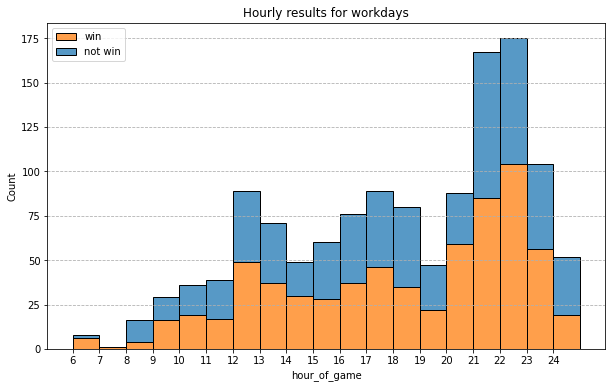

In [32]:
workdays = chess_df[chess_df.day_of_week < 6]
plt.figure(figsize=(10, 6))
sns.histplot(data=workdays, x=workdays.hour_of_game, hue='my_result', bins=19, multiple='stack')
plt.xticks(ticks=range(25))
plt.legend(('win', 'not win'), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.title('Hourly results for workdays')
plt.plot();

Пик игр по будням приходится на вечернее послерабочее время (20-23 часа). При этом процент побед очевидно меньше.

#### Создаю признак part_of_day - время дня, когда игралась партия и посмотрим, как я играю в разное время дня.

In [33]:
chess_df['part_of_day'] = chess_df.hour_of_game.replace([4, 5, 6, 7, 8, 9, 10, 11], 'morning') \
                                    .replace([12, 13, 14, 15], 'afternoon').replace([16, 17, 18, 19], 'evening') \
                                    .replace([20, 21, 22, 23, 24, 25, 26], 'night')

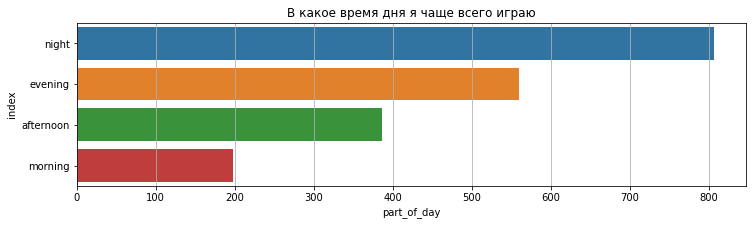

In [34]:
plt.figure(figsize=(12, 3))
sns.barplot(data=chess_df.part_of_day.value_counts().to_frame().reset_index(), x='part_of_day', y='index')
plt.title('В какое время дня я чаще всего играю')
plt.grid(axis='x');

Больше всего игр я сыграл после 20 часов вечера, меньше всего - утром

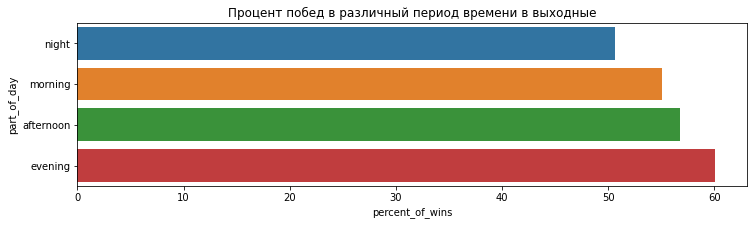

In [35]:
c = chess_df[chess_df.day_of_week >= 6].groupby('part_of_day').agg({'my_result': 'mean'}).reset_index().sort_values(by='my_result')
c.my_result = c.my_result * 100
c = c.rename(columns={'my_result': 'percent_of_wins'})
plt.figure(figsize=(12, 3))
plt.title('Процент побед в различный период времени в выходные')
sns.barplot(x=c.percent_of_wins, y=c.part_of_day, orient='h');

В выходные наиболее успешное время для меня - вечер, но не слишком поздно. После 20 часов результаты падают

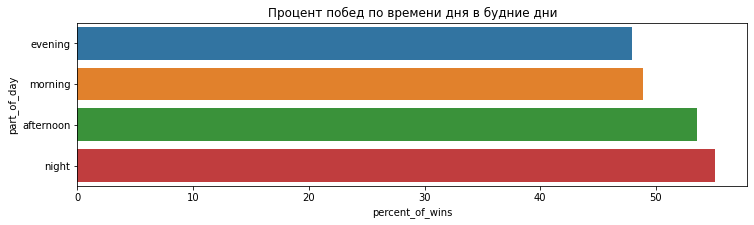

In [36]:
d = chess_df[chess_df.day_of_week < 6].groupby('part_of_day').agg({'my_result': 'mean'}).reset_index().sort_values(by='my_result')
d.my_result = d.my_result * 100
d = d.rename(columns={'my_result': 'percent_of_wins'})
plt.figure(figsize=(12, 3))
plt.title('Процент побед по времени дня в будние дни')
sns.barplot(x=d.percent_of_wins, y=d.part_of_day, orient='h');

В рабочие дни ситация почти противоположная. После 20 часов я играю успешно, а вот вечер с 16 по 20 часов не очень хорошее время. Получается, сразу после работы лучше не играть

#### Проанализировав полученные данные, я решил оставить данные part_of_day, только обработаю эту переменную dummy-кодированием, чтобы получить 4 категориальные переменные, в какое время я играл. Также создам категориальную переменную its_weekend, принимающую значения 0 - будний день, 1 - выходной. Соответственно, признак hour_of_game можно будет удалить

In [37]:
chess_df = pd.get_dummies(data=chess_df)

In [38]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 14)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control,day_of_week,hour_of_game,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0,2,12,1,0,0,0
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0,2,12,1,0,0,0
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0,2,12,1,0,0,0
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1,1,22,0,0,0,1
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1,1,22,0,0,0,1


In [39]:
chess_df['its_weekend'] = chess_df.day_of_week.replace([1, 2, 3, 4, 5], 0).replace([6, 7], 1).astype('uint8')

Удаляю теперь не нужные категориальные признаки hour_of_game и day_of_week. При обучении линейных моделей они могут оказаться вредными для точности предсказания.

In [40]:
chess_df.drop(columns=['hour_of_game', 'day_of_week'], inplace=True)

In [41]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 13)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night,its_weekend
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0,1,0,0,0,0
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0,1,0,0,0,0
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0,1,0,0,0,0
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1,0,0,0,1,0
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1,0,0,0,1,0


Судя по статистике, на выходных я играю лучше. Но, возможно, это связано с тем, что я чаще играю в турнирах на выходных, где мне попадаются соперники с меньшим рейтингом, отсюда больше побед. Давайте сравним разницу рейтинга в моих партиях в выходные и в будни

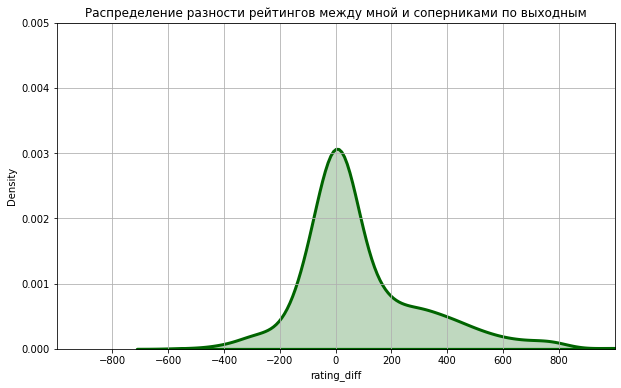

In [42]:
plt.figure(figsize=(10, 6))
sns.kdeplot(chess_df[chess_df['its_weekend'] == 1].rating_diff, lw=3, color='darkgreen', fill=True)
plt.xticks(ticks=range(-800, 801, 200))
plt.xlim([-1000, 1000])
plt.ylim([0, 0.005])
plt.grid(linestyle='-')
plt.title('Распределение разности рейтингов между мной и соперниками по выходным')
plt.plot();

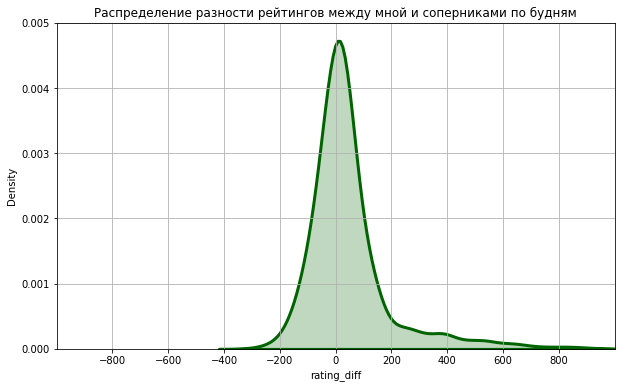

In [43]:
plt.figure(figsize=(10, 6))
sns.kdeplot(chess_df[chess_df['its_weekend'] == 0].rating_diff, lw=3, color='darkgreen', fill=True)
plt.xticks(ticks=range(-800, 801, 200))
plt.xlim([-1000, 1000])
plt.ylim([0, 0.005])
plt.grid(linestyle='-')
plt.title('Распределение разности рейтингов между мной и соперниками по будням')
plt.plot();

Из графиков распределений можно сделать вывод, что рейтинги моих соперников не сильно разнятся в будни и в выходные. В выходные разброс рейтингов больше, опять-таки из-за турниров, где самый различный контингент. Можно также подсчитать среднюю разность рейтингов для выходных и будней

In [44]:
print('Среднее различие рейтинга с соперником по выходным = ', chess_df[chess_df['its_weekend'] == 1].rating_diff.mean())
print('Среднее различие рейтинга с соперником по будням = ', chess_df[chess_df['its_weekend'] == 0].rating_diff.mean())

Среднее различие рейтинга с соперником по выходным =  86.28698224852072
Среднее различие рейтинга с соперником по будням =  47.77664576802508


В целом, в выходные чаще попадаются менее рейтинговые соперники

#### Создаю переменные, которые содержат информацию: сколько партий я сыграл за последние 7 дней (last_7days_games) и какой процент побед в этих партиях (last_7days_win_rate)

In [45]:
dated_X = chess_df.sort_values(by='Date_Time').set_index('date_') #создаю датафрейм с DateTime индексом
#создаю датафрейм, где каждому дню соответствует, сколько партий я сыграл за последние 7 дней
last_7d_stats = dated_X[['my_result']].resample('d').count().rolling(8, min_periods=1).sum() - dated_X[['my_result']].resample('d').count()
my_wins = dated_X[['my_result']].loc[ dated_X['my_result'] == 1] #для подсчете моих побед
#создаю датафрейм, где каждому дню соответствует, сколько партий я выиграл за последние 7 дней
last_7d_wins = my_wins.resample('d').count().rolling(8, min_periods=1).sum() - my_wins.resample('d').count()
#объединяю два датафрейма в один
last_7d_stats = last_7d_stats.merge(last_7d_wins, left_index=True, right_index=True, how='inner')
last_7d_stats = last_7d_stats.reset_index().rename(columns={'my_result_x': 'last_7days_games',
                                                                 'my_result_y': 'last_7days_wins'})
#далее подсчитываю процент выигранных партий за последние 7 дней - отношение кол-ва побед к кол-ву игр
#для этого есть вспомогательная функция в библиотеке chess_lib - count_rate

In [46]:
last_7d_stats['last_7days_win_rate'] = count_rate(last_7d_stats.last_7days_wins, last_7d_stats.last_7days_games).astype('float32')
last_7d_stats[['last_7days_games', 'last_7days_wins']] = last_7d_stats[['last_7days_games', 'last_7days_wins']].astype('uint16')
print('Размерность датафрейма статистики за 7 последних дней:', last_7d_stats.shape)
last_7d_stats.head()

Размерность датафрейма статистики за 7 последних дней: (330, 4)


,date_,last_7days_games,last_7days_wins,last_7days_win_rate
0,2020-05-26,0,0,0.000
1,2020-05-27,10,8,0.800
2,2020-05-28,15,10,0.667
3,2020-05-29,18,13,0.722
4,2020-05-30,31,20,0.645


Данные статистики за последние 7 дней для каждой игры получены. Можно глянуть на мой прогресс по количеству игр и побед во времени, а затем соединить эти данные с основным датафреймом

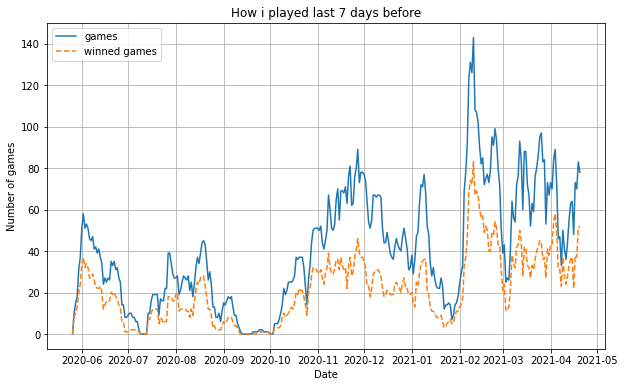

In [47]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(last_7d_stats.date_, last_7d_stats.last_7days_games)
ax1.plot(last_7d_stats.date_, last_7d_stats.last_7days_wins, linestyle='--')
ax1.xaxis.set_label_text('Date')
ax1.yaxis.set_label_text('Number of games')
ax1.legend(('games', 'winned games'), loc='upper left')
plt.grid()
plt.title('How i played last 7 days before');

In [48]:
chess_df = pd.merge(left=chess_df, right=last_7d_stats, on='date_', how='inner')

In [49]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 16)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night,its_weekend,last_7days_games,last_7days_wins,last_7days_win_rate
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0,1,0,0,0,0,78,52,0.667
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0,1,0,0,0,0,78,52,0.667
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0,1,0,0,0,0,78,52,0.667
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1,0,0,0,1,0,83,51,0.614
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1,0,0,0,1,0,83,51,0.614


#### Создаю переменные, содержащие информацию о моей статистике за предыдущие партии, которые я сыграл в текущий день. count_today_games - сколько партий выграл сегодня до этого, win_rate_today_games - процент побед в текущий день

In [50]:
dd = chess_df[['Date_Time', 'date_', 'my_result']] #промежуточный датафрейм
list_count_today_games, list_count_today_wins= [], []
for i, row in dd.iterrows():
    #print(row)
    subseries_games = dd[['Date_Time']].loc[(dd['Date_Time'] < row[0]) & (dd['date_'] == row[1])] #серия с играми за день
    subseries_wins = dd[['Date_Time']].loc[(dd['Date_Time'] < row[0]) & (dd['date_'] == row[1]) & dd['my_result'] == 1] #с победами
    list_count_today_games.append(subseries_games.shape[0]) #считаю количество игр за каждый день и добавляю в список
    list_count_today_wins.append(subseries_wins.shape[0]) #аналогично для побед
df_count_today = pd.DataFrame(data=np.array((list_count_today_games, list_count_today_wins)).T,
                             columns=['count_today_games', 'win_today_games']) #создаю датафрейм со статистикой

In [51]:
df_count_today['win_rate_today_games'] = count_rate(df_count_today.win_today_games, df_count_today.count_today_games).astype('float32')
df_count_today[['count_today_games', 'win_today_games']] = df_count_today[['count_today_games', 'win_today_games']].astype('uint16')
print('Размерность датафрейма статистики за текущий день:', df_count_today.shape)
df_count_today.head()

Размерность датафрейма статистики за текущий день: (1952, 3)


,count_today_games,win_today_games,win_rate_today_games
0,2,1,0.5
1,1,0,0.0
2,0,0,0.0
3,5,5,1.0
4,4,4,1.0


Датафрейм со статистикой за текущий день для каждой партии создан. Объединяем его с основным датафреймом!

In [52]:
chess_df = pd.merge(left=chess_df, right=df_count_today, left_index=True, right_index=True, how='inner')

Удаляю из набора данных уже не нужные признаки времени Date_Time и date_

In [53]:
chess_df.drop(columns=['Date_Time', 'date_'], inplace=True)

In [54]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 17)


,my_result,my_color,event,my_rating,rating_diff,time_control,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night,its_weekend,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
0,0,0,0,2194,136,0,1,0,0,0,0,78,52,0.667,2,1,0.5
1,1,1,0,2190,101,0,1,0,0,0,0,78,52,0.667,1,0,0.0
2,0,0,0,2190,-1,0,1,0,0,0,0,78,52,0.667,0,0,0.0
3,1,1,1,2342,69,1,0,0,0,1,0,83,51,0.614,5,5,1.0
4,1,0,1,2342,747,1,0,0,0,1,0,83,51,0.614,4,4,1.0


Проверяем полученный датафрейм на типы данных

In [55]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 1951
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   my_result              1952 non-null   uint8  
 1   my_color               1952 non-null   uint8  
 2   event                  1952 non-null   uint8  
 3   my_rating              1952 non-null   uint16 
 4   rating_diff            1952 non-null   int16  
 5   time_control           1952 non-null   uint8  
 6   part_of_day_afternoon  1952 non-null   uint8  
 7   part_of_day_evening    1952 non-null   uint8  
 8   part_of_day_morning    1952 non-null   uint8  
 9   part_of_day_night      1952 non-null   uint8  
 10  its_weekend            1952 non-null   uint8  
 11  last_7days_games       1952 non-null   uint16 
 12  last_7days_wins        1952 non-null   uint16 
 13  last_7days_win_rate    1952 non-null   float32
 14  count_today_games      1952 non-null   uint16 
 15  win_

Посмотрим таблицу корреляции признаков

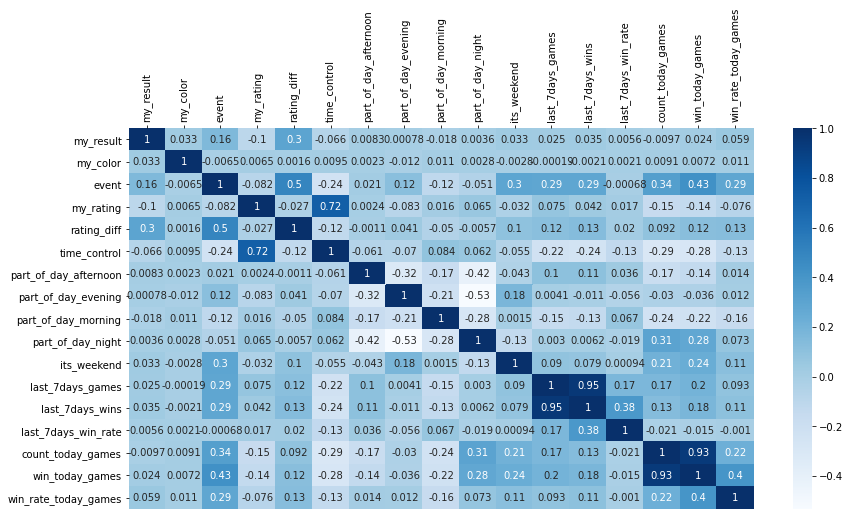

In [56]:
plt.figure(figsize=(14, 7))
g = sns.heatmap(chess_df.corr(), annot=True, cmap=plt.cm.Blues)
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90);

## 3. Создание тренировочного и тестового набора данных

Разделяю основной датафрейм на вектор признаков (X) и вектор целевой переменной my_result (y).

In [57]:
X = chess_df.drop(columns='my_result')
y = chess_df.my_result

In [58]:
print('Размерности X и y: ', X.shape, y.shape)

Размерности X и y:  (1952, 16) (1952,)


Для линейных методов лучше произвести масштабирование признаков. Произведем масштабирование для всех признаков, кроме бинарных. Поскольку бинарные признаки в таблице имеют тип данных uint8, я осуществляю обучение StandardScaler() только по признакам не типа uint8, а затем их добавляю к датафрейму X вместо соответствующих исходных признаков

In [59]:
feat_scaling = X.dtypes[X.dtypes != 'uint8'].index #признаки для масштабирования

In [60]:
X[feat_scaling].head()

,my_rating,rating_diff,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
0,2194,136,78,52,0.667,2,1,0.5
1,2190,101,78,52,0.667,1,0,0.0
2,2190,-1,78,52,0.667,0,0,0.0
3,2342,69,83,51,0.614,5,5,1.0
4,2342,747,83,51,0.614,4,4,1.0


In [61]:
scaler = StandardScaler()

In [62]:
scaler.fit(X[feat_scaling])

StandardScaler()

Создаю промежуточный датафрейм, где хранятся все отмасштабированные признаки

In [63]:
X_scaled_part = pd.DataFrame(scaler.transform(X[feat_scaling]), columns=feat_scaling)
X_scaled_part.head()

,my_rating,rating_diff,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
0,0.105329,0.415896,0.950008,1.554877,1.215053,-0.646176,-0.654828,0.040888
1,0.060119,0.221518,0.950008,1.554877,1.215053,-0.784027,-0.889925,-1.483133
2,0.060119,-0.344956,0.950008,1.554877,1.215053,-0.921878,-0.889925,-1.483133
3,1.778082,0.043801,1.142723,1.488434,0.757218,-0.232623,0.285561,1.564908
4,1.778082,3.809186,1.142723,1.488434,0.757218,-0.370474,0.050464,1.564908


In [64]:
X_scaled = X.drop(columns=feat_scaling)
X_scaled = pd.merge(left=X_scaled, right=X_scaled_part, left_index=True, right_index=True, how='inner')

In [65]:
print('Размерность масштабированного датафрейма X:', X_scaled.shape)
X_scaled.head()

Размерность масштабированного датафрейма X: (1952, 16)


,my_color,event,time_control,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night,its_weekend,my_rating,rating_diff,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
0,0,0,0,1,0,0,0,0,0.105329,0.415896,0.950008,1.554877,1.215053,-0.646176,-0.654828,0.040888
1,1,0,0,1,0,0,0,0,0.060119,0.221518,0.950008,1.554877,1.215053,-0.784027,-0.889925,-1.483133
2,0,0,0,1,0,0,0,0,0.060119,-0.344956,0.950008,1.554877,1.215053,-0.921878,-0.889925,-1.483133
3,1,1,1,0,0,0,1,0,1.778082,0.043801,1.142723,1.488434,0.757218,-0.232623,0.285561,1.564908
4,0,1,1,0,0,0,1,0,1.778082,3.809186,1.142723,1.488434,0.757218,-0.370474,0.050464,1.564908


Датафрейм с масштабированными признаками готов!

Разделяем наши данные на тренировочный и проверочный набор

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=28, shuffle=True)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=28, shuffle=True)

Убеждаемся, что в обоих случаях (немасштабированные данные и масштабированные данные) используется одинаковый набор объектов:

In [67]:
X_train

,my_color,event,my_rating,rating_diff,time_control,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night,its_weekend,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
1247,0,0,2239,-27,1,0,0,0,1,0,63,30,0.476,11,5,0.455
1276,0,0,2138,-31,0,0,0,0,1,0,63,22,0.349,21,12,0.571
841,0,0,2219,39,1,0,0,1,0,0,14,9,0.643,0,0,0.000
1874,1,0,2155,-10,1,0,0,1,0,1,46,27,0.587,0,0,0.000
387,1,1,2267,423,1,0,0,0,1,0,76,43,0.566,11,4,0.364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,0,0,2221,19,1,0,0,0,1,0,63,22,0.349,14,9,0.643
1056,0,0,2104,9,0,0,0,0,1,0,44,19,0.432,14,6,0.429
1302,0,0,2230,-13,1,0,1,0,0,0,71,32,0.451,4,0,0.000
1541,1,0,2185,21,1,0,1,0,0,1,28,15,0.536,2,1,0.500


In [68]:
X_train_scaled

,my_color,event,time_control,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night,its_weekend,my_rating,rating_diff,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
1247,0,0,1,0,0,0,1,0,0.613936,-0.489351,0.371864,0.093129,-0.434880,0.594482,0.285561,-0.096274
1276,0,0,0,0,0,0,1,0,-0.527605,-0.511566,0.371864,-0.438415,-1.531956,1.972991,1.931242,0.257299
841,0,0,1,0,0,1,0,0,0.387888,-0.122809,-1.516739,-1.302175,1.007732,-0.921878,-0.889925,-1.483133
1874,1,0,1,0,0,1,0,1,-0.335464,-0.394939,-0.283366,-0.106200,0.523982,-0.921878,-0.889925,-1.483133
387,1,1,1,0,0,0,1,0,0.930403,2.009798,0.872922,0.956889,0.342575,0.594482,0.050464,-0.373646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,0,0,1,0,0,0,1,0,0.410493,-0.233883,0.371864,-0.438415,-1.531956,1.008034,1.225950,0.476758
1056,0,0,0,0,0,0,1,0,-0.911886,-0.289419,-0.360451,-0.637744,-0.814970,1.008034,0.520659,-0.175523
1302,0,0,1,0,1,0,0,0,0.512215,-0.411600,0.680208,0.226015,-0.650840,-0.370474,-0.889925,-1.483133
1541,1,0,1,0,1,0,0,1,0.003607,-0.222775,-0.977138,-0.903517,0.083423,-0.646176,-0.654828,0.040888


In [69]:
print('Размерность обучающего набора: ', X_train.shape, y_train.shape)
print('Размерность тестового набора: ', X_test.shape, y_test.shape)

Размерность обучающего набора:  (1307, 16) (1307,)
Размерность тестового набора:  (645, 16) (645,)


Наборы данных для обучения и проверки готовы! Давайте обучим несколько типов классификаторов и сравним их результаты

## 4. Обучение моделей, сравнение результатов

Задаю параметры для кросс-валидации:

In [70]:
kf = KFold(n_splits=5, random_state=28, shuffle=True)

### 4.1. Метрические и линейные методы

#### Nearest Neighbors

Для начала обучим простую модель - метод k ближайших соседей. Основной параметр настройки, который будем подбирать - n_neighbors (число соседей). Алгоритм обучения относится к числу метрических, поэтому (теоретически) лучше использовать набор масштабированных данных. Попробуем рассчитать точность и построить кривые валидации вначале на масшабируемых данных, затем - на обычных.

kNN при масштабировании признаков:

In [71]:
k_list = [i for i in range(1, 16, 2)] + [i for i in range(20, 46, 5)] + [i for i in range(50, 151, 25)] #все значения k
accuracy_knn_train, accuracy_knn_test = [], []

In [72]:
%%time
for k in k_list:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    cross_val_sc = np.mean(cross_val_score(clf_knn, X_train_scaled, y_train, cv=kf))
    clf_knn.fit(X_train_scaled, y_train)
    accuracy_knn_train.append(cross_val_sc)
    accuracy_knn_test.append(accuracy_score(y_test, clf_knn.predict(X_test_scaled)))

Wall time: 6.32 s


In [73]:
len(accuracy_knn_train), len(accuracy_knn_test)

(19, 19)

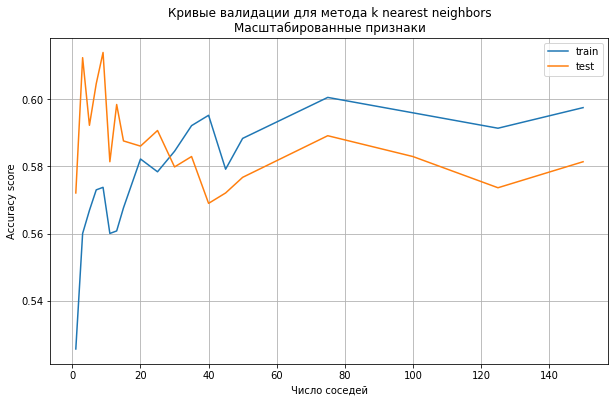

In [74]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_list, y=accuracy_knn_train, label='train')
sns.lineplot(x=k_list, y=accuracy_knn_test, label='test')
plt.title('Кривые валидации для метода k nearest neighbors\nМасштабированные признаки')
plt.grid()
plt.legend()
plt.xlabel('Число соседей')
plt.ylabel('Accuracy score');

In [75]:
max_score_knn = round(max(accuracy_knn_test), 3)
best_n_neighbors = k_list[accuracy_knn_test.index(max(accuracy_knn_test))]
print(f'kNN обеспечивает максимальный score = {max_score_knn} при k соседей = {best_n_neighbors}')

kNN обеспечивает максимальный score = 0.614 при k соседей = 9


kNN без масштабирования признаков:

In [76]:
%%time
accuracy_knn_train2, accuracy_knn_test2 = [], []
for k in k_list:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    cross_val_sc = np.mean(cross_val_score(clf_knn, X_train, y_train, cv=kf))
    clf_knn.fit(X_train, y_train)
    accuracy_knn_train2.append(cross_val_sc)
    accuracy_knn_test2.append(accuracy_score(y_test, clf_knn.predict(X_test)))

Wall time: 4.94 s


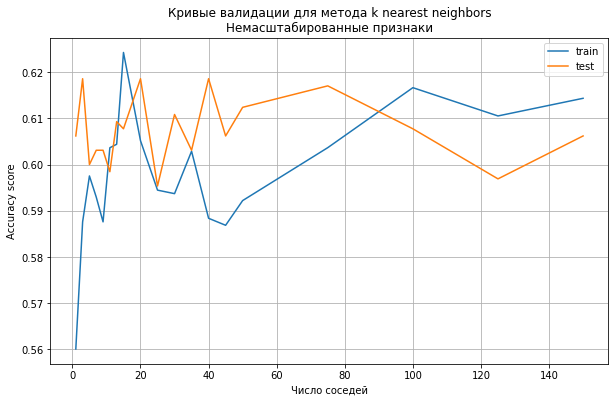

In [77]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_list, y=accuracy_knn_train2, label='train')
sns.lineplot(x=k_list, y=accuracy_knn_test2, label='test')
plt.title('Кривые валидации для метода k nearest neighbors\nНемасштабированные признаки')
plt.grid()
plt.legend()
plt.xlabel('Число соседей')
plt.ylabel('Accuracy score');

In [78]:
max_score_knn2 = round(max(accuracy_knn_test2), 3)
best_n_neighbors2 = k_list[accuracy_knn_test2.index(max(accuracy_knn_test2))]
print(f'kNN обеспечивает максимальный score = {max_score_knn2} при k соседей = {best_n_neighbors2}')

kNN обеспечивает максимальный score = 0.619 при k соседей = 3


Итого по методу kNN:

accuracy score составил 0.614 (с масштабированием признаков) и 0.619 (без масштабирования признаков)

#### Support vector machine

Обучим модель метода опорных векторов. Для неё также желательно использовать масштабированные данные, т.к. это один из видов линейных алгоритмов. Но проверим оба варианта. Основной параметр настройки - C (степень регуляризации).

SVC с масштабированием признаков:

In [79]:
c_list = np.power(10, range(-4, 5), dtype = np.float)
accuracy_svc_train, accuracy_svc_test = [], []

In [80]:
%%time
for c in c_list:
    clf_svc = SVC(C=c, random_state=28)
    cross_val_sc = np.mean(cross_val_score(clf_svc, X_train_scaled, y_train, cv=kf))
    clf_svc.fit(X_train_scaled, y_train)
    accuracy_svc_train.append(cross_val_sc)
    accuracy_svc_test.append(accuracy_score(y_test, clf_svc.predict(X_test_scaled)))

Wall time: 17.5 s


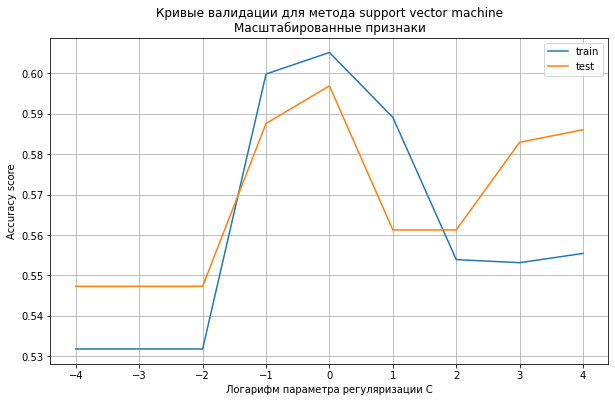

In [81]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.log10(c_list), y=accuracy_svc_train, label='train')
sns.lineplot(x=np.log10(c_list), y=accuracy_svc_test, label='test')
plt.title('Кривые валидации для метода support vector machine\nМасштабированные признаки')
plt.grid()
plt.legend()
plt.xlabel('Логарифм параметра регуляризации С')
plt.ylabel('Accuracy score');

In [82]:
max_score_svc = round(max(accuracy_svc_test), 3)
best_c_svc = c_list[accuracy_svc_test.index(max(accuracy_svc_test))]
print(f'SVC обеспечивает максимальный score = {max_score_svc} при C = {best_c_svc}')

SVC обеспечивает максимальный score = 0.597 при C = 1.0


SVC без масштабирования признаков:

In [83]:
%%time
accuracy_svc_train2, accuracy_svc_test2 = [], []
for c in c_list:
    clf_svc = SVC(C=c, random_state=28)
    cross_val_sc = np.mean(cross_val_score(clf_svc, X_train, y_train, cv=kf))
    clf_svc.fit(X_train, y_train)
    accuracy_svc_train2.append(cross_val_sc)
    accuracy_svc_test2.append(accuracy_score(y_test, clf_svc.predict(X_test)))

Wall time: 5.55 s


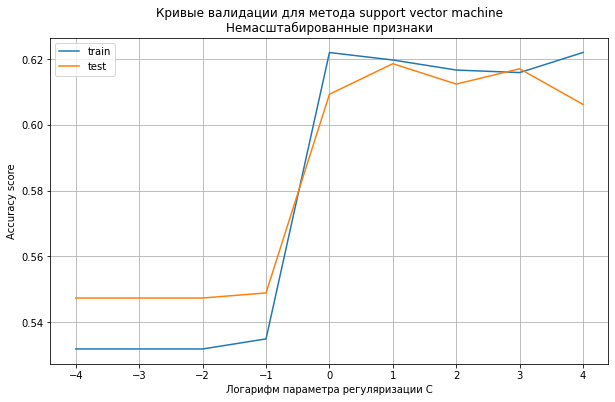

In [84]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.log10(c_list), y=accuracy_svc_train2, label='train')
sns.lineplot(x=np.log10(c_list), y=accuracy_svc_test2, label='test')
plt.title('Кривые валидации для метода support vector machine\nНемасштабированные признаки')
plt.grid()
plt.legend()
plt.xlabel('Логарифм параметра регуляризации С')
plt.ylabel('Accuracy score');

In [85]:
max_score_svc2 = round(max(accuracy_svc_test2), 3)
best_c_svc2 = c_list[accuracy_svc_test2.index(max(accuracy_svc_test2))]
print(f'SVC обеспечивает максимальный score = {max_score_svc2} при C = {best_c_svc2}')

SVC обеспечивает максимальный score = 0.619 при C = 10.0


Итого по методу Support vector machine:

accuracy score составил 0.597 (с масштабированием признаков) и 0.619 (без масштабирования признаков). Очевидно, что масштабирование оказывает негативное влияние на точность моделей в данном случае

#### Logistic Regression

Логистическая регрессия - один из основных видов классификаторов. Аналогично SVC, подбирать будем параметр регуляризации C и смотреть на обоих типах данных.

Logistic regression с масштабированием признаков:

In [86]:
accuracy_logit_train, accuracy_logit_test = [], []

In [87]:
%%time
for c in c_list:
    clf_logit = LogisticRegression(C=c, random_state=28)
    cross_val_sc = np.mean(cross_val_score(clf_logit, X_train_scaled, y_train, cv=kf))
    clf_logit.fit(X_train_scaled, y_train)
    accuracy_logit_train.append(cross_val_sc)
    accuracy_logit_test.append(accuracy_score(y_test, clf_logit.predict(X_test_scaled)))

Wall time: 1.39 s


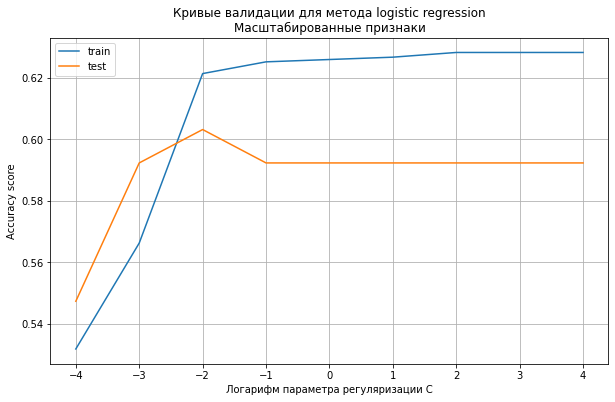

In [88]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.log10(c_list), y=accuracy_logit_train, label='train')
sns.lineplot(x=np.log10(c_list), y=accuracy_logit_test, label='test')
plt.title('Кривые валидации для метода logistic regression\nМасштабированные признаки')
plt.grid()
plt.legend()
plt.xlabel('Логарифм параметра регуляризации С')
plt.ylabel('Accuracy score');

In [89]:
max_score_logit = round(max(accuracy_logit_test), 3)
best_c_logit = c_list[accuracy_logit_test.index(max(accuracy_logit_test))]
print(f'Logistic regression обеспечивает максимальный score = {max_score_logit} при C = {best_c_logit}')

Logistic regression обеспечивает максимальный score = 0.603 при C = 0.01


Logistic regression без масштабирования признаков:

In [90]:
%%time
accuracy_logit_train2, accuracy_logit_test2 = [], []
for c in c_list:
    clf_logit = LogisticRegression(C=c, random_state=28)
    cross_val_sc = np.mean(cross_val_score(clf_logit, X_train, y_train, cv=kf))
    clf_logit.fit(X_train, y_train)
    accuracy_logit_train2.append(cross_val_sc)
    accuracy_logit_test2.append(accuracy_score(y_test, clf_logit.predict(X_test)))

c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Wall time: 4.28 s


c:\python\ml_coursera\venv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


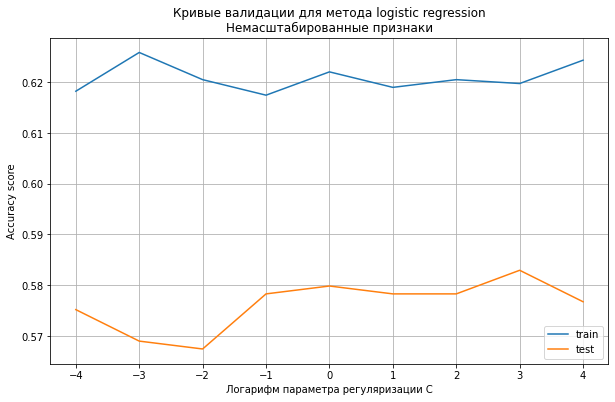

In [91]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.log10(c_list), y=accuracy_logit_train2, label='train')
sns.lineplot(x=np.log10(c_list), y=accuracy_logit_test2, label='test')
plt.title('Кривые валидации для метода logistic regression\nНемасштабированные признаки')
plt.grid()
plt.legend()
plt.xlabel('Логарифм параметра регуляризации С')
plt.ylabel('Accuracy score');

In [92]:
max_score_logit2 = round(max(accuracy_logit_test2), 3)
best_c_logit2 = c_list[accuracy_logit_test2.index(max(accuracy_logit_test2))]
print(f'Logistic regression обеспечивает максимальный score = {max_score_logit2} при C = {best_c_logit2}')

Logistic regression обеспечивает максимальный score = 0.583 при C = 1000.0


Итого по логистической регрессии:

accuracy score составил 0.603 (с масштабированием признаков) и 0.583 (без масштабирования признаков). При этом, без масштабирования вывалилась куча предупреждений. Для логистической регрессии масштабирование оказалось полезным в данном случае

### 4.2. Деревья решений и их композиции

#### Decision tree

Для деревьев решений масштабирование признаков не требуется. Алгоритм решающего дерева склонен к переобучению. Основной параметр, который будем подбирать - глубина дерева max_depth

In [93]:
accuracy_tree_train, accuracy_tree_test = [], []

In [94]:
%%time
for depth_ in range(1, 11):
    clf_tree = DecisionTreeClassifier(max_depth=depth_, random_state=28)
    cross_val_sc = np.mean(cross_val_score(clf_tree, X_train_scaled, y_train, cv=kf))
    clf_tree.fit(X_train, y_train)
    accuracy_tree_train.append(cross_val_sc)
    accuracy_tree_test.append(accuracy_score(y_test, clf_tree.predict(X_test)))

Wall time: 752 ms


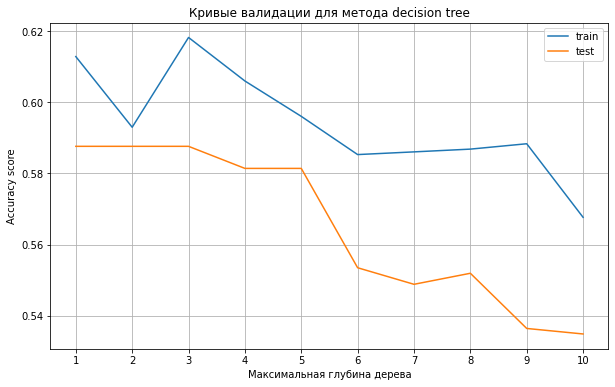

In [95]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=accuracy_tree_train, label='train')
sns.lineplot(x=range(1, 11), y=accuracy_tree_test, label='test')
plt.title('Кривые валидации для метода decision tree')
plt.grid()
plt.legend()
plt.xticks(range(1, 11))
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Accuracy score');

In [96]:
max_score_tree = round(max(accuracy_tree_test), 3)
best_depth_tree = 1
print(f'Decision tree обеспечивает максимальный score = {max_score_tree} при max_depth = {best_depth_tree}')

Decision tree обеспечивает максимальный score = 0.588 при max_depth = 1


Итого по decision tree:

Как и ожидалось, алгоритм сильно переобучается. Наилучший score =  0.577 при глубине 1, 2 или 3. Далее, с увеличеснием глубины, качество предсказания на проверочных данных падает.

#### Random Forest

Основные параметры настройки случайного леса - max_depth (максимальная глубина деревьев) и n_estimators (количество деревьев в лесу). n_estimators оставим равным 100.

In [97]:
accuracy_rf_train, accuracy_rf_test, depth_list = [], [], range(1, 21)

In [98]:
%%time
for depth_ in depth_list:
    clf_rf = RandomForestClassifier(max_depth=depth_, n_estimators=100, random_state=28)
    cross_val_sc = np.mean(cross_val_score(clf_rf, X_train, y_train, cv=kf))
    clf_rf.fit(X_train, y_train)
    accuracy_rf_train.append(cross_val_sc)
    accuracy_rf_test.append(accuracy_score(y_test, clf_rf.predict(X_test)))

Wall time: 47.3 s


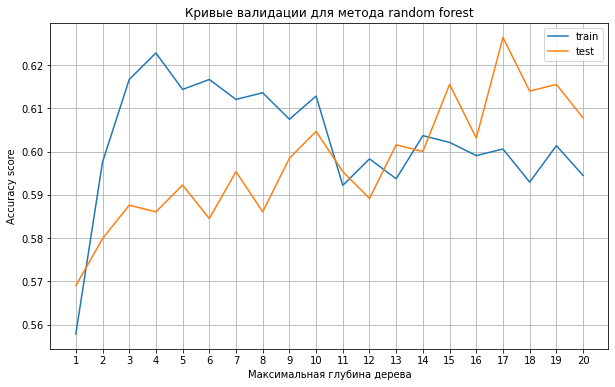

In [99]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=depth_list, y=accuracy_rf_train, label='train')
sns.lineplot(x=depth_list, y=accuracy_rf_test, label='test')
plt.title('Кривые валидации для метода random forest')
plt.grid()
plt.legend()
plt.xticks(depth_list)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Accuracy score');

In [100]:
max_score_rf = round(max(accuracy_rf_test), 3)
best_depth_rf = depth_list[accuracy_rf_test.index(max(accuracy_rf_test))]
print(f'Random forest обеспечивает максимальный score = {max_score_rf} при max_depth = {best_depth_rf} и n_estimators = 100')

Random forest обеспечивает максимальный score = 0.626 при max_depth = 17 и n_estimators = 100


Итого по Random forest:

accuracy score = 0.626, пока это наилучший показатель

#### Gradient Boosting

Градиентный бустинг над решающими деревьями. Будем настраивать два параметра - max_depth (максимальная глубина деревьев) и learning_rate - скорость обучения

In [101]:
accuracy_gb_train, accuracy_gb_test, depth_range, l_rates = [], [], range(5, 9), [0.1, 0.3]

In [102]:
%%time
for l in l_rates:
    acc_train_temp, acc_test_temp = [], []
    for depth_ in depth_range:
        clf_gb = GradientBoostingClassifier(max_depth=depth_, learning_rate=l, random_state=28)
        cross_val_sc = np.mean(cross_val_score(clf_gb, X_train, y_train, cv=kf))
        clf_gb.fit(X_train, y_train)
        acc_train_temp.append(cross_val_sc)
        acc_test_temp.append(accuracy_score(y_test, clf_gb.predict(X_test)))
    accuracy_gb_train.append(acc_train_temp)
    accuracy_gb_test.append(acc_test_temp)
    #print(accuracy_gb_train)

Wall time: 46.8 s


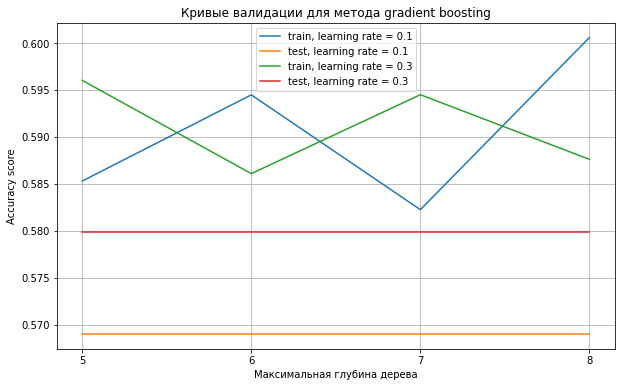

In [104]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=depth_range, y=accuracy_gb_train[0], label='train, learning rate = 0.1')
sns.lineplot(x=depth_range, y=accuracy_rf_test[0], label='test, learning rate = 0.1')
sns.lineplot(x=depth_range, y=accuracy_gb_train[1], label='train, learning rate = 0.3')
sns.lineplot(x=depth_range, y=accuracy_rf_test[1], label='test, learning rate = 0.3')
plt.title('Кривые валидации для метода gradient boosting')
plt.grid()
plt.legend()
plt.xticks(depth_range)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Accuracy score');

In [105]:
max_for_lrates = list(map(max, accuracy_gb_test)) #список максимумов для каждого learning_rate 
max_score_gb = max(max_for_lrates) #наилучший score среди всех
index_best_lrate = max_for_lrates.index(max_score_gb) #индекс learning_rate, где был наилучший score
best_lrate = l_rates[index_best_lrate] #наилучший learning_rate нахожу по его индексу
best_depth_gb = depth_range[accuracy_gb_test[index_best_lrate].index(max_score_gb)] #нахожу наилучшую глубину в списке внутри списка
max_score_gb = round(max_score_gb, 3)
print(f'Gradient boosting обеспечивает максимальный score = {max_score_gb} \
при max_depth = {best_depth_gb} и learning_rate = {best_lrate}')

Gradient boosting обеспечивает максимальный score = 0.619 при max_depth = 8 и learning_rate = 0.3


Итого по Gradient boosting:

accuracy score = 0.619

Подведем итоги по классификаторам. Посторим сводную таблицу со значения accuracy_score для каждого классификатора.

In [106]:
clf_scores = [max_score_knn2, max_score_svc2, max_score_logit, max_score_tree, max_score_rf, max_score_gb]
clf_names = ['kNN', 'SVC', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']

In [107]:
print('Сводная таблица значений accuracy_score')
pd.DataFrame(data=np.array((clf_names, clf_scores)).T, columns=['Estimator', 'Accuracy_score']) \
            .sort_values(by='Accuracy_score', ascending=False)

Сводная таблица значений accuracy_score


,Estimator,Accuracy_score
4,Random Forest,0.626
0,kNN,0.619
1,SVC,0.619
5,Gradient Boosting,0.619
2,Logistic Regression,0.603
3,Decision Tree,0.588


### Наилучшим классификатором для данного набора данных оказался Random Forest.

### Accuracy score = 0.626

Напоследок, давайте обучим модель Random Forest с наилучшими параметрами, сделаем прогноз, затем взглянем на скэттер-плот зависимости распределения результатов от рейтинга и разницы рейтинга (по тестовой выборке) и по итогу сравним истинное распределение с предсказанными значениями. Сделаем это для того, чтобы посмотреть, какие игры смог предсказать классификатор, а какие нет.

In [108]:
best_clf = RandomForestClassifier(max_depth=17, n_estimators=100, random_state=28)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

In [109]:
comparing_data_test = pd.DataFrame(data=np.array((X_test.my_rating, X_test.rating_diff, y_test, y_pred)).T, 
                                   columns=['my_rating', 'rating_diff', 'y_true', 'y_pred'])

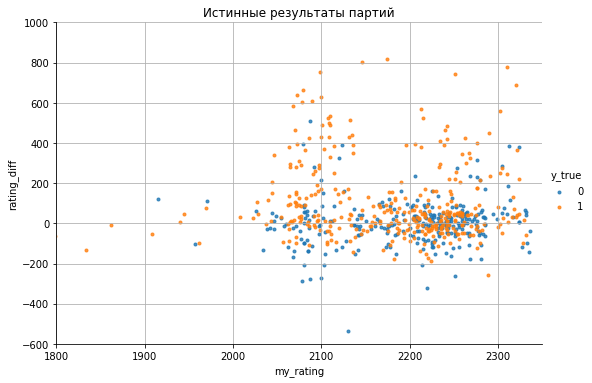

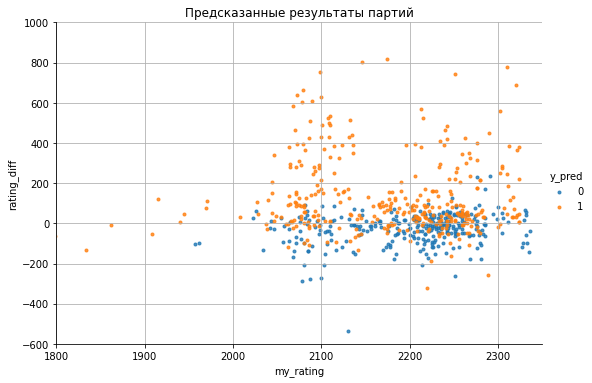

In [110]:
ax = sns.lmplot(x='my_rating', y='rating_diff', data=comparing_data_test, 
                hue='y_true', fit_reg=False, markers='.', aspect=1.5)
plt.title('Истинные результаты партий')
plt.grid()
plt.xlim([1800, 2350])
plt.ylim([-600, 1000]);
ax2 = sns.lmplot(x='my_rating', y='rating_diff', data=comparing_data_test, 
                 hue='y_pred', fit_reg=False, markers='.', aspect=1.5)
plt.title('Предсказанные результаты партий')
plt.grid()
plt.xlim([1800, 2350])
plt.ylim([-600, 1000]);

Верхний скэттер-плот показывает истинные результаты моих партий. Как мы видим, много результатов вперемешку - близкие по параметрам игры имеют разные результаты. Игра в шахматы непредсказуема, а в блиц, да еще и онлайн - непредсказуема втройне! И, несмотря на то, что другие признаки могут внести некоторую ясность, всё равно, предсказать результаты с точностью более, чем 62% - довольно неплохой результат. Поэтому, полученные результаты можно признать вполне удовлетворительными.

In [111]:
accuracy_score(y_pred, y_test)

0.6263565891472869

In [112]:
y_pred_proba = best_clf.predict_proba(X_test)
proba_class_win = y_pred_proba[:,1] #вероятности класса "выиграю"
pr_thresholds = np.linspace(0.45, 0.55, num=21)
acc_scores_thres = []
pr_thresholds

array([0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 ])

In [113]:
for pr_threshold in pr_thresholds:
    new_y_pred = np.where(proba_class_win>=pr_threshold, 1, 0)
    acc_scores_thres.append(accuracy_score(new_y_pred, y_test))

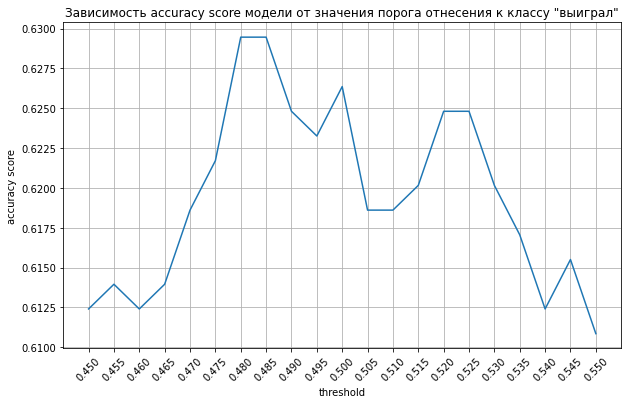

In [116]:
plt.figure(figsize=(10, 6))
q = sns.lineplot(x=pr_thresholds, y=acc_scores_thres)
plt.title('Зависимость accuracy score модели от значения порога отнесения к классу "выиграл"')
plt.xticks(pr_thresholds)
plt.xlabel('threshold')
plt.ylabel('accuracy score')
q.xaxis.set_tick_params(rotation=45)
plt.grid();

In [115]:
max_acc = max(acc_scores_thres)
best_threshold = round(pr_thresholds[acc_scores_thres.index(max_acc)], 2)
print(f'Наилучший accuracy score для Random Forest достигается при границе вероятностей между классами 0 и 1,\
равной {best_threshold}.\nAccuracy_score = {round(max_acc, 3)}')

Наилучший accuracy score для Random Forest достигается при границе вероятностей между классами 0 и 1,равной 0.48.
Accuracy_score = 0.629


## Заключение

Данный проект был направлен на решение вопроса - возможно ли предсказать результат моей партии на сайте lichess.org, имея базу данных моих предыдущих партий на этом сайте? Ответ - можно, и доля правильно предсказанных ответов = 62,9 %. Такое значение достигается при использовании случайного леса. Учитывая непредсказуемость блиц-партий, это довольно неплохой результат. Для достижения такого показателя, была проделана следующая работа:

- Выгружена база моих партий, из которой был создан первичный датасет

- Проведен анализ данных для формирования информативных признаков для обучения модели

- На основе данных первичного датасета и анализа были сформированы признаки для обучающего и тестового набора данных

- Проведено обучение 6 типов классификаторов и их сравнение. Параметр оценки адекватности модели - метрика accuracy score на тестовых данных

- Далее из обучающей и тестовой выборки были удалены признаки, и оставлены только те, которые имели наибольшее значение при обучении моделей. Методом перебора различных комбинаций признаков для обучающей выборки были найдены такие комбинации, при которых acuracy score был максимальный для каждого типа классификатора.

- В итоге, наилучший accuracy score (0.629) у Random Forest Classifier глубиной = 17, количеством деревьев = 100. Классификатор относит объект (партию) к классу "выиграю" при вероятности класса = 0.48)

#### Спасибо, что дочитали до конца!

Теперь хочется, построить свой тотализатор. Это будет оконная программа, куда будут заноситься данные о текущей партии, а программа будет рассчитывать и отображать вероятность моей победы!